### Auto Encoder

- Reducing the Dimensionality of Data with Neural Networks 논문에서 제안 된 기법입니다.
- 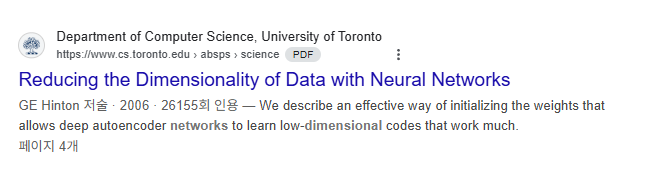
- 입력이 들어왔을 때 입력을 더 작은 차원의 벡터로 압축 한 뒤,
- 압축된 입력으로부터 원본을 다시 복구하는 학습을 합니다.
- 이 과정에서 데이터를 압축하는 Layer를 `Encoder`
- 데이터를 복구하는 Layer를 `Decoder` 라고 합니다.
- Auto Encoder는 이 학습을 통해 `Encoder` 가 `Latent Vector (잠재 벡터)` 를 찾습니다.
- `Latent Vector` 란 `특징만 추출된 벡터`를 의미한다 라고 보시면 됩니다.
- decoder는 `Latent Vector` 를 잘 찾았는지 검사하는 용도로 사용됩니다.
- Decoder는 “Latent Vector가 정말로 충분한 정보를 담고 있는지”를 검사하는 역할을 합니다.
  - (잘 압축되었다면 잘 복원될 것이고, 못 압축했다면 복원이 엉망일 것입니다.)

- 결국 Encoder는 불필요한 잡음(noise)을 버리고 중요한 특징만 남기는 방법을 배우게 됩니다.

- 특징을 추출하여 다시 복구했을 때, 특징이 잘 추출되었다면 복구가 잘 될것이라고 가정한 것입니다.
- 이거 말고 정답을 줄 방법도 따로 없기 때문에 자기 자신을 정답으로 쓰면서, 학습을 진행합니다.
- 우리가 직접 정답을 주지 않아도 되기 때문에 `비 지도 학습` 에 들어갑니다.
- 이러한 학습 과정을 거치면서, Encoder 는 이미지의 잡음은 제거하고, 특성을 추출하는 방법을 배웁니다.

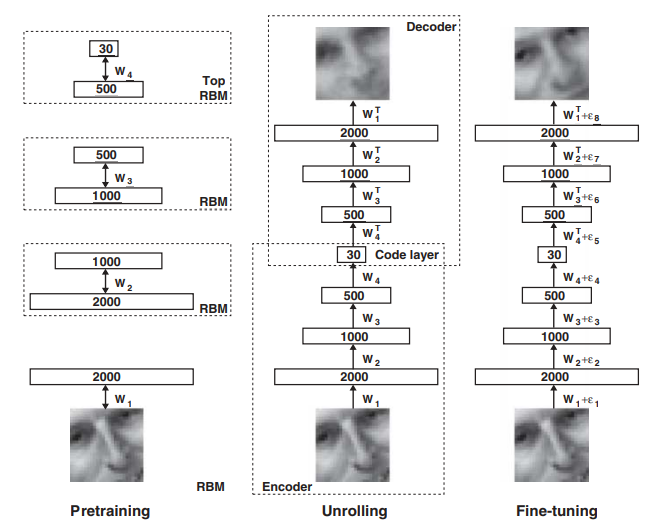

`pretraining`, `finetuning` 은 따로 진행하지 않고, 일반적인 복구 학습 만 진행합니다.

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# cuda 가 존재하면 gpu 를 사용하고, 그렇지 않다면 cpu 를 사용합니다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 변환할 때 쓴다
'''
transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
이런 식으로 더 많은 짓을 하게 할 수도 있지만. 지금은 그런 짓은 하지 않는다.
아무것도 안하면 MNIST 이미지인 PIL 파일을 Tensor 로 바꾸는 것만 한다. (.ToTensor()) 의 역할
'''
transform = transforms.ToTensor()

# MNIST Dataset을 다운로드 받습니다.
# 해당 경로에 이미 있으면 다운로드 받지 않습니다.
train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform,
)

# 데이터셋을 받아옵니다.
# 이 때 모든 데이터를 한번에 학습 할 수 없기 때문에 128개씩 뽑아와서 학습 합니다.
# shuffle 옵션을 넣으면 데이터를 순서대로 넣는게 아니라 섞어서 넣습니다.
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Using device: cuda


In [ ]:
# 오토인코더 모델 정의
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        '''
            데이터를 압축
        '''
        # nn.Sequential 안에 들어있으면, 안에 들어있는 nn layer 들을 연속적으로 사용합니다.
        self.encoder = nn.Sequential(
            # 학습 데이터로, MNIST를 사용합니다.
            # MNIST 는 28 * 28 (784) 개의 픽셀로 이루어져 있습니다.
            # nn.Linear(X, Y)의 의미는, 크기 X의 입력 벡터를 받아)
            # 내부적으로 (Y × X) weight matrix 와 bias를 이용해
            # 크기 Y의 벡터로 선형 변환한다는 뜻입니다. (Wx + b)
            #
            # 이 레이어는 입력의 모든 뉴런이 출력의 모든 뉴런과 연결되어 있으므로
            # 이것은 Fully Connected Layer (완전 연결층) 입니다.
            # Dropout을 사용하기도 하는데 이것은 연결 구조를 변경하는 것이 아니라 학습 중 일부 연결을 임시로 무시하는 기법입니다.
            # dropout을 왜 쓰는지는 차후에 설명하겠습니다. 우선 이 코드에서는 사용하지 않겠습니다.
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            # 최종 Latent Vector 는 3차원 Vector 로 압축
            nn.Linear(12, 3)
        )
        '''
            데이터를 복구
            복구 과정은 압축과정과 같을 필요는 없지만. 그냥 같게 만들었습니다.
        '''
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            # 여기서 원본 복구
            nn.Linear(128, 28*28),
            nn.Sigmoid()   # 출력 데이터를 0과 1 사이로 스케일링
        )

    def forward(self, x):
        # x: (batch, 1, 28, 28) 라고 가정
        x = x.view(x.size(0), -1) 
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    # latent vector 를 한번에 볼 수 있게 하는 헬퍼 함수
    def encode(self, x):
        x = x.view(x.size(0), -1)
        return self.encoder(x)

model = Autoencoder().to(device)

In [3]:
print("MNIST 첫 번째 데이터 (tensor):")

# 픽셀 형태로 저장되어있음을 알 수 있다.
# 이렇게 생겼기 때문에 데이터를 저런식으로 넣는다.
print(train_dataset[0][0])
print("Label:", train_dataset[0][1])

MNIST 첫 번째 데이터 (tensor):
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000

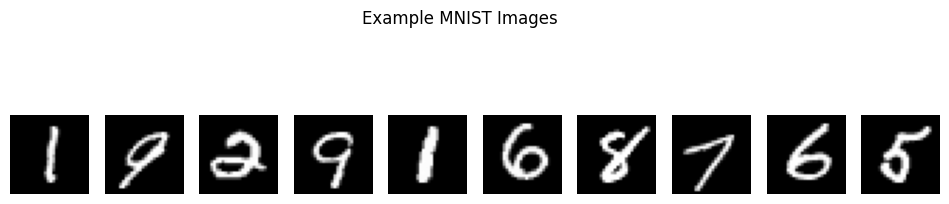

In [4]:
def show_examples():
    images, labels = next(iter(train_loader))
    images = images[:10]

    plt.figure(figsize=(12, 3))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.axis("off")
    plt.suptitle("Example MNIST Images")
    plt.show()

show_examples()

In [5]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20

for epoch in range(1, num_epochs + 1):
    # 모델을 학습 할 때는 반드시 모델을 학습 모드로 돌려놓고 사용해야 한다.
    model.train()
    total_loss = 0

    for images, _ in train_loader:
        images = images.to(device)

        outputs = model(images)
        images_flat = images.view(images.size(0), -1)
        loss = criterion(outputs, images_flat)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"[{epoch}/{num_epochs}] Loss: {avg_loss:.6f}")

torch.save(model.state_dict(), "autoencoder.pth")
print("모델 저장 완료: autoencoder.pth")

[1/20] Loss: 0.068304
[2/20] Loss: 0.050341
[3/20] Loss: 0.043262
[4/20] Loss: 0.040861
[5/20] Loss: 0.039445
[6/20] Loss: 0.038222
[7/20] Loss: 0.037398
[8/20] Loss: 0.036722
[9/20] Loss: 0.036141
[10/20] Loss: 0.035690
[11/20] Loss: 0.035213
[12/20] Loss: 0.034837
[13/20] Loss: 0.034508
[14/20] Loss: 0.034209
[15/20] Loss: 0.033949
[16/20] Loss: 0.033668
[17/20] Loss: 0.033487
[18/20] Loss: 0.033288
[19/20] Loss: 0.033123
[20/20] Loss: 0.032947
모델 저장 완료: autoencoder.pth


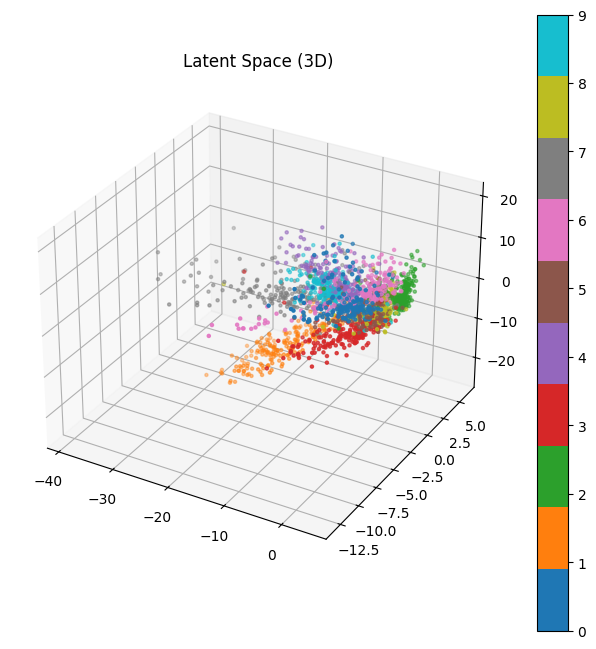

In [ ]:
'''
모델 파일이 이미 있다면, 위의 학습을 진행하지 않아도 된다.
model_path = "autoencoder.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
'''

# 모델을 평가할 때는, 반드시 평가모드로 전환하여 사용해야 한다.
model.eval()

latents = []
labels = []

with torch.no_grad():
    for images, y in test_loader:
        images = images.to(device)
        z = model.encode(images)
        latents.append(z.cpu())
        labels.append(y)

latents = torch.cat(latents, dim=0).numpy()
labels = torch.cat(labels, dim=0).numpy()

# 3D scatter
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter(
    latents[:2000, 0],   # x
    latents[:2000, 1],   # y
    latents[:2000, 2],   # z
    c=labels[:2000],
    cmap="tab10",
    s=5,
)

plt.colorbar(scatter)
ax.set_title("Latent Space (3D)")
plt.show()

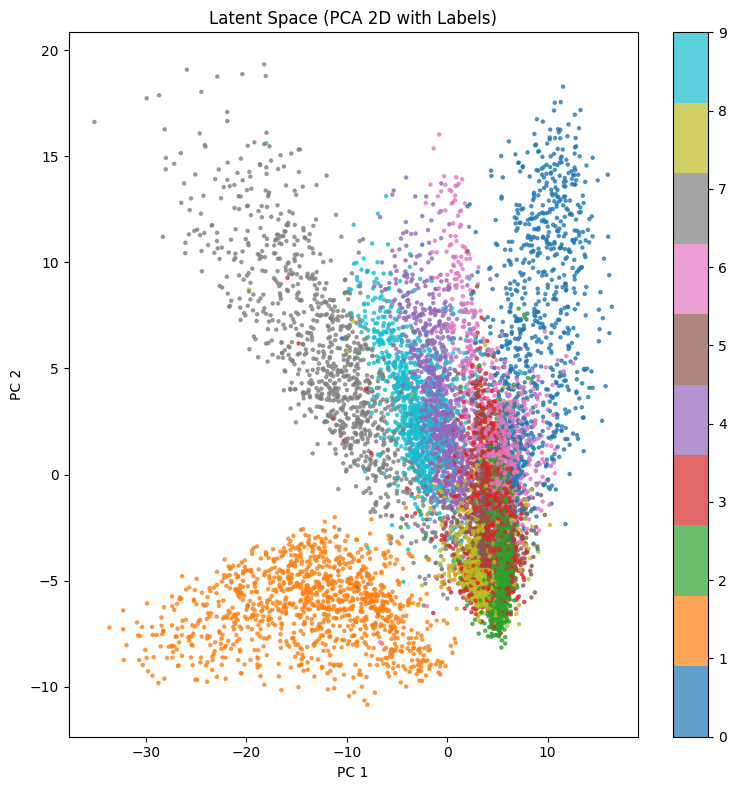

In [14]:
pca = PCA(n_components=2)
z_2d = pca.fit_transform(latents)

plt.figure(figsize=(8, 8))

plt.scatter(
    z_2d[:, 0],
    z_2d[:, 1],
    c=labels,
    cmap="tab10",
    s=5,
    alpha=0.7
)

plt.title("Latent Space (PCA 2D with Labels)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar()
plt.tight_layout()
plt.show()

t-SNE 입력 크기: (2000, 3)


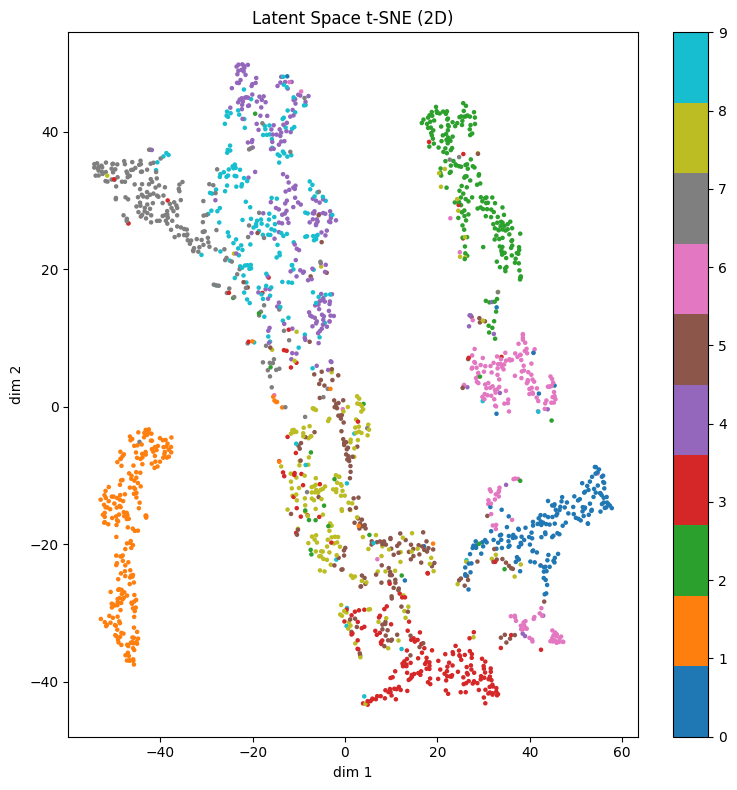

In [10]:
def visualize_latent_tsne(model, data_loader, device, max_samples=2000):
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for images, y in data_loader:
            images = images.to(device)
            z = model.encode(images)          # (batch, 3)
            latents.append(z.cpu())
            labels.append(y)

            # 너무 많이 모이면 t-SNE가 느려지니까 max_samples 개까지만 사용
            if sum(l.size(0) for l in latents) >= max_samples:
                break

    latents = torch.cat(latents, dim=0)[:max_samples].numpy()   # (N, 3)
    labels = torch.cat(labels, dim=0)[:max_samples].numpy()     # (N,)

    print("t-SNE 입력 크기:", latents.shape)

    tsne = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate=200,
        init="random",
        random_state=42,
    )
    z_2d = tsne.fit_transform(latents)   # (N, 2)

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(
        z_2d[:, 0],
        z_2d[:, 1],
        c=labels,
        cmap="tab10",
        s=5,
    )
    plt.colorbar(scatter)
    plt.title("Latent Space t-SNE (2D)")
    plt.xlabel("dim 1")
    plt.ylabel("dim 2")
    plt.tight_layout()
    plt.show()

visualize_latent_tsne(model, test_loader, device, max_samples=2000)

시각화된 결과 파일들은 다음과 같습니다.

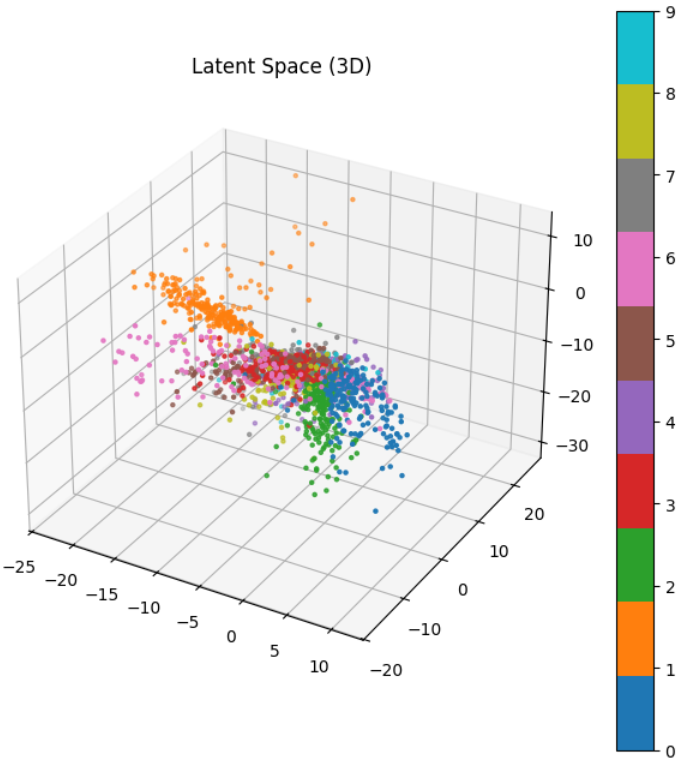
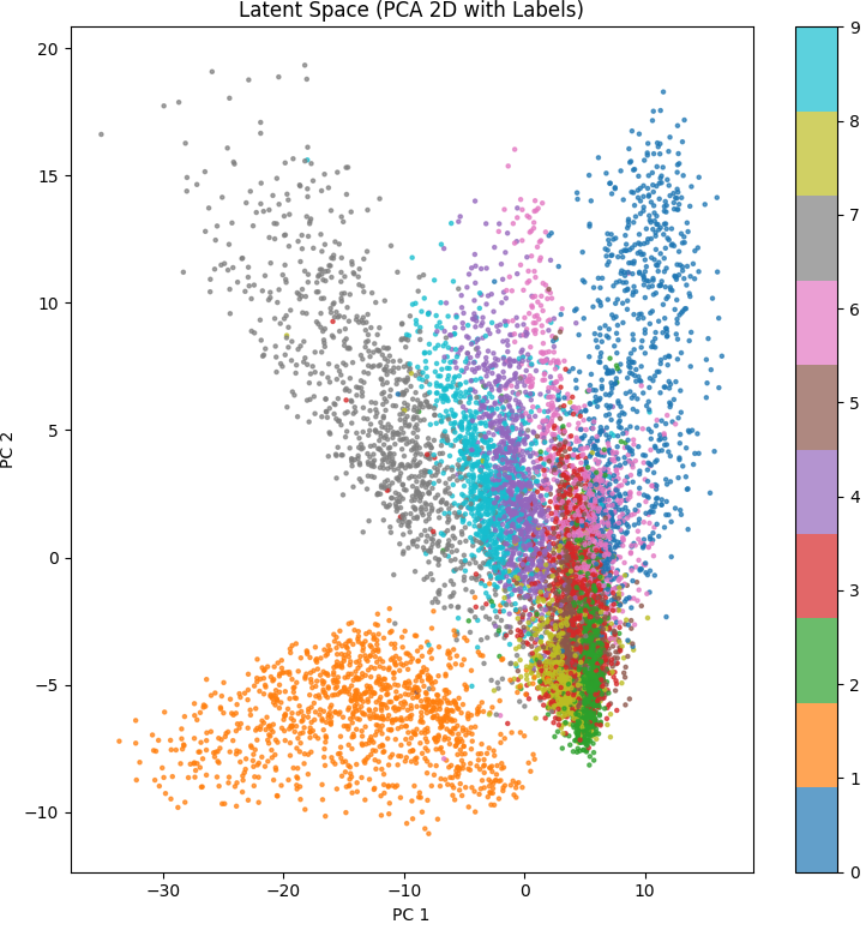
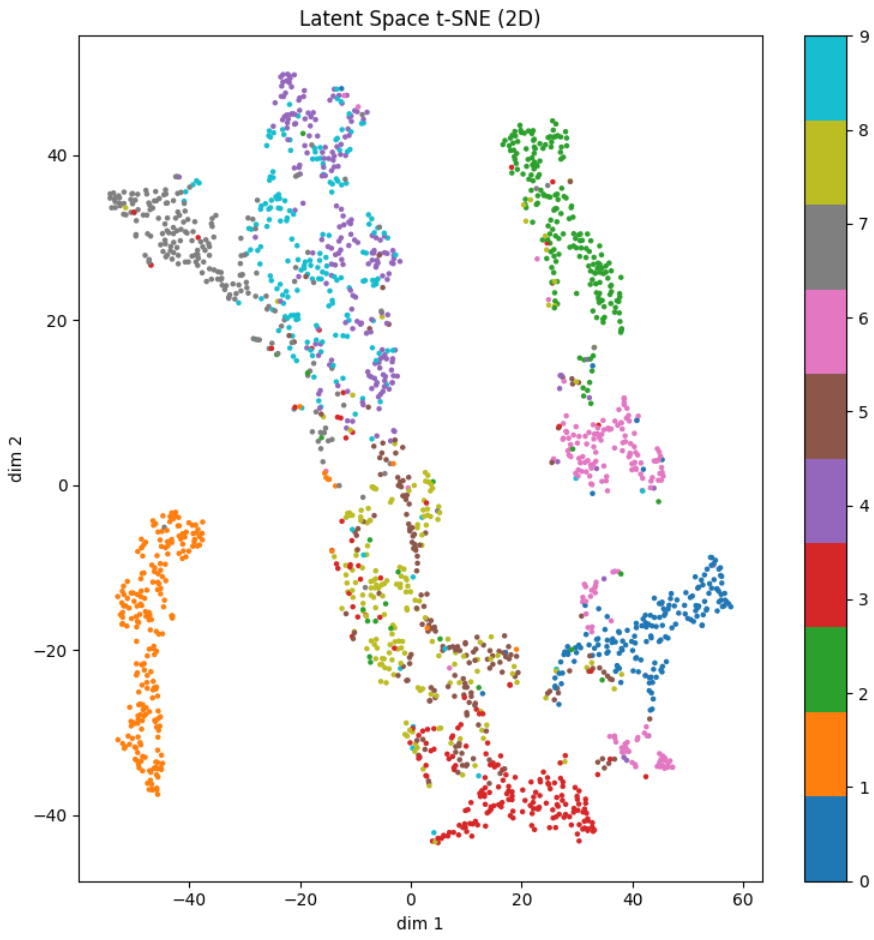

학습은 정상적으로 잘 진행 되고, 학습된 데이터를 시각화 테스트 해 봤을때 이런 데이터가 나온다.


전체적으로 모든 데이터가 다 깔끔하게 분류가 되는건 아니지만, 어느정도 군집화 해서 모여있음을 볼 수 있다.

이런식으로 특징을 뽑아서 Latent Vector 를 만든 것을 Auto Encoder 라고 한다.